<a href="https://colab.research.google.com/github/gtoge/Chicago_Crime_Analysis/blob/master/ChicagoCrimeRateAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago crime dataset analysis
  Listerning to the news about the high crime rate in Chicago[As well as other cities in the world] raises a lot of concern.We intern to use data science to get valuable insight from the city of Chicago crime datathat can help improve safety and reduce crime rate.
  we will be using data from the city of chicago portal[https://data.cityofchicago.org/].
We will follow the following steps
- Problem Statement
- Setup a pyspark environment
- Download Aquisition
- Data Preprocessing
- Exploratory Analysis
- Data Modeling
- Decision Making
- Prediction


## Problem Statement
To have an overall view on crimes in Chicago we will try to answer the following questions using Data Analysis
- How has the number of crimes change over the years?
- How has the number of some specific crimes varied across the years?
- Are there any particular trends in the crimes being committed?
-Which crimes are the most frequent?
- What percentage of reported crimes that leads to an arrest ?
- where are certain crimes common?
- Are there certain locations for certain crimes( eg theft,battery etc)?
- How has the number of arrest corrsponding tie crimes change over time in chicago?
- - When is the peak of crimal activities? (day,month,year)
- Which Communities have the highest crime?
- Which crimes are predominant in each community?




## Setting PySpark Environment
- We need to install the following dependencies:
- Apache Spark 
- hadoop 
- java 
- Findspark[for testing the environment]

In [0]:
#Apache spark dependencies download
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
#Setting up the environment path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
#testing our environment
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Checking the installation of spark
!ls

sample_data  spark-2.4.5-bin-hadoop2.7	spark-2.4.5-bin-hadoop2.7.tgz


## Data Aquisition
-Download data from [https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e]

In [5]:
#Downloading Data
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD

--2020-04-27 00:34:13--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [  <=>               ]   1.56G  3.20MB/s    in 8m 34s  

2020-04-27 00:42:47 (3.11 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1676102257]



In [6]:
#Checking my downloaded files
 !ls

'rows.csv?accessType=DOWNLOAD'	 spark-2.4.5-bin-hadoop2.7
 sample_data			 spark-2.4.5-bin-hadoop2.7.tgz


In [0]:
# renaming our file
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv

In [8]:
# Checking if file wa updated
!ls

reported-crimes.csv  spark-2.4.5-bin-hadoop2.7
sample_data	     spark-2.4.5-bin-hadoop2.7.tgz


## Data Preperation
We will do data cleaning
- Replacing Community Area with Area Name
- Check for duplicates
- Check for missing data
- Checking for Outliers[Due to the nature of the data and the analysis involve,this will not be necessary]


### Creating  a parkSession

In [0]:
#import and create sparksession object
from pyspark.sql import SparkSession 
spark=SparkSession.builder.appName('rc').getOrCreate()

### Displaying a data sample

In [10]:
#import the required functions and libraries
from pyspark.sql.functions import  to_timestamp,col,lit
#load the dataset and create sprk dataframe
df=spark.read.csv('reported-crimes.csv',inferSchema=True,header=True)
df.show(5)

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|01/01/2001 11:00:...|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false| 412|       4|   8|            45|      

### Comunity Area names
- comunity area columns is intergers. 
- we will source and add the real names instead.
- Sourced from Chicago Tribune at http://www.chicagotribune.com/chi-community-areas-htmlstory.html

In [0]:
areaNames = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [12]:
## Splitting data into community area and area name
ComArea_AreaName = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in areaNames.strip().split('\n')]]
# displaying the 5 rows
ComArea_AreaName[:5]

[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

In [0]:
# Coverting our ComArea_AreaName data to a dataframe
ComArea_AreaName_df=spark.createDataFrame(ComArea_AreaName, ['Community Area', 'Area Name'])

In [14]:
#Join the community area to our main data frame
PrepData = ComArea_AreaName_df.join(df, on='Community Area', how='right')
PrepData.show(10)

+--------------+---------------+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+--------+---------+--------+
|Community Area|      Area Name|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------------+---------------+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+--------+---------+--------+
|             8|Near North Side|11227495|   JB147292|03/20/2014 09:00:...|     003XX E ERIE ST|1154|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|  

### Checking and Handling duplicates

In [15]:
#Checking for Duplicates
print('Count of rows: {0}'.format(PrepData.count()))
print('Count of distinct rows: {0}'.format(PrepData.distinct().count()))

Count of rows: 7107558
Count of distinct rows: 7107558


There are no duplcates  based on ID

### Checking For/dropping Missing Data

In [16]:
## Checking for Missing Data
## This code check for missing Data per row
from pyspark.sql.functions import isnull, when, count, col
missData = PrepData.select([count(when(isnull(c), c)).alias(c) for c in PrepData.columns]).toPandas()
missData

,Community Area,Area Name,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,613493,613586,0,4,0,0,0,0,0,6536,0,0,0,47,614827,0,68288,68288,0,0,68288,68288,68288


In [0]:
# droping the null values
df = PrepData.dropna()

In [19]:
# Verifying our data for null
missData = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()
missData

,Community Area,Area Name,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Exploration

In [20]:
#Getting the shape of the data 
print((df.count(),len(df.columns)))

(6428153, 23)


In [21]:
#display columns and columns type in dataframe
# NB advisable to manual construct schemas
df.printSchema()

root
 |-- Community Area: integer (nullable = true)
 |-- Area Name: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [22]:
#Descriptive Statistics
# We will look into the statistics of numerical data,Ward,Community Area

df.describe('Beat','District','Community Area','Ward').show()


+-------+------------------+-----------------+------------------+------------------+
|summary|              Beat|         District|    Community Area|              Ward|
+-------+------------------+-----------------+------------------+------------------+
|  count|           6428153|          6428153|           6428153|           6428153|
|   mean|1185.3028958707112|11.28633808187204| 37.55103697749571|22.700465903658486|
| stddev| 702.2528265077336|6.939369978499845|21.524689080902142| 13.83203613378033|
|    min|               111|                1|                 1|                 1|
|    max|              2535|               31|                77|                50|
+-------+------------------+-----------------+------------------+------------------+







### Data Range
- The span of our data

In [23]:
import datetime
from pyspark.sql.functions import *
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2001 01:00:00 AM|12/31/2019 12:58:00 AM|
+----------------------+----------------------+



### Converting our dates to a timestamp type

In [0]:
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY')) #adding a month column to be able to view stats on a monthly basis

In [25]:
df.select(['date','date_time', 'month'])\
  .show(n=5, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|05/04/2019 02:00:00 PM|2019-05-04 14:00:00|2019-01-01|
|05/22/2019 01:30:00 AM|2019-05-22 01:30:00|2019-01-01|
|05/22/2019 01:42:00 AM|2019-05-22 01:42:00|2019-01-01|
|05/23/2019 03:30:00 PM|2019-05-23 15:30:00|2019-01-01|
|05/24/2019 06:00:00 PM|2019-05-24 18:00:00|2019-01-01|
+----------------------+-------------------+----------+
only showing top 5 rows



### Crime Types
- ranking the various crimes
- Answering the question , which crimes are the most frequent?



In [30]:
# Quantitative look into Crime Types
crime_type= df.groupBy('primary Type').count().orderBy('count', ascending=False)
crime_type.show()


+--------------------+-------+
|        primary Type|  count|
+--------------------+-------+
|               THEFT|1364733|
|             BATTERY|1177504|
|     CRIMINAL DAMAGE| 733527|
|           NARCOTICS| 654423|
|             ASSAULT| 405477|
|       OTHER OFFENSE| 399396|
|            BURGLARY| 367610|
| MOTOR VEHICLE THEFT| 291387|
|  DECEPTIVE PRACTICE| 256760|
|             ROBBERY| 242787|
|   CRIMINAL TRESPASS| 184452|
|   WEAPONS VIOLATION|  73511|
|        PROSTITUTION|  60692|
|PUBLIC PEACE VIOL...|  46192|
|OFFENSE INVOLVING...|  43774|
| CRIM SEXUAL ASSAULT|  25347|
|         SEX OFFENSE|  23118|
|INTERFERENCE WITH...|  16603|
|            GAMBLING|  13362|
|LIQUOR LAW VIOLATION|  12250|
+--------------------+-------+
only showing top 20 rows



In [26]:
#Plot
#We transform crimeType to pd datadrame to plot
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
#Converting data to panda
crime_type_df= crime_type.toPandas()
crime_type_df.head(5)

,primary Type,count
0,THEFT,1364733
1,BATTERY,1177504
2,CRIMINAL DAMAGE,733527
3,NARCOTICS,654423
4,ASSAULT,405477


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

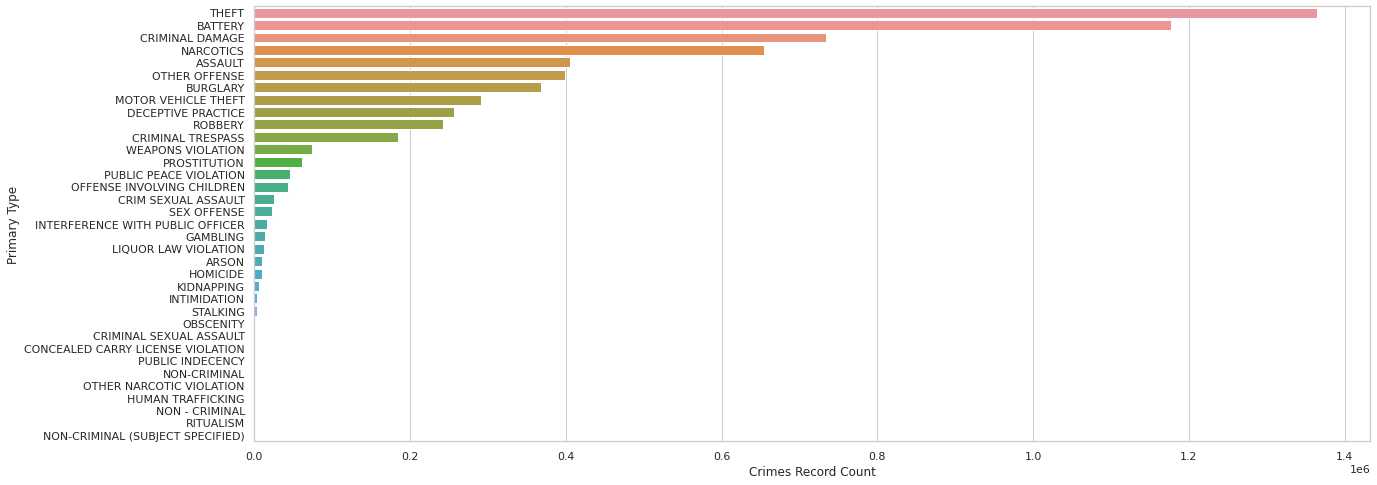

In [35]:
#plots
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary Type',data= crime_type_df)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

### Percentage of reported crimes that results to an arrest
- We answer the question
-  What percentage of reported crimes that leads to an arrest ?

In [36]:
# Boolean count of Arrests
df.groupBy('Arrest').count().show()

+------+-------+
|Arrest|  count|
+------+-------+
|  true|1750050|
| false|4678103|
+------+-------+



In [37]:
# Percentage Of Aresst
# succesfull arrest divided total arrest
PerArrest=(df.filter(col('Arrest') == 'true').count() / df.select('Arrest').count())*100
PerArrest

27.2247720301617

### Location With Highest Number of repoported crimes
- where are certain crimes common?

In [58]:
# Number of location recorded in the dataset
df.select('location description').distinct().count()

212

In [38]:
df.groupby('Location Description').count().orderBy('count', ascending=False).show(20)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1647995|
|           RESIDENCE|1067712|
|           APARTMENT| 704206|
|            SIDEWALK| 650812|
|               OTHER| 239444|
|PARKING LOT/GARAG...| 181909|
|               ALLEY| 143580|
|SCHOOL, PUBLIC, B...| 131438|
|    RESIDENCE-GARAGE| 122226|
|  SMALL RETAIL STORE| 118487|
|RESIDENCE PORCH/H...| 112373|
|VEHICLE NON-COMME...| 107814|
|          RESTAURANT| 105455|
|    DEPARTMENT STORE|  81630|
|  GROCERY FOOD STORE|  80884|
|RESIDENTIAL YARD ...|  74902|
|         GAS STATION|  71031|
|       PARK PROPERTY|  49422|
|CHA PARKING LOT/G...|  44938|
|COMMERCIAL / BUSI...|  44088|
+--------------------+-------+
only showing top 20 rows



### Crime Location for certain crimes
- Are there certain locations for certain crimes( eg theft,battery etc)?

In [42]:
df.groupby('primary Type','Location Description').count().orderBy('count', ascending=False).show(20)

+-------------------+--------------------+------+
|       primary Type|Location Description| count|
+-------------------+--------------------+------+
|              THEFT|              STREET|369244|
|    CRIMINAL DAMAGE|              STREET|261956|
|            BATTERY|           APARTMENT|246734|
|            BATTERY|           RESIDENCE|239758|
|MOTOR VEHICLE THEFT|              STREET|229853|
|          NARCOTICS|              STREET|226153|
|          NARCOTICS|            SIDEWALK|213085|
|            BATTERY|              STREET|197744|
|            BATTERY|            SIDEWALK|178834|
|      OTHER OFFENSE|           RESIDENCE|178829|
|    CRIMINAL DAMAGE|           RESIDENCE|137205|
|              THEFT|           RESIDENCE|137093|
|           BURGLARY|           RESIDENCE|124723|
|           BURGLARY|           APARTMENT|110111|
|            ASSAULT|              STREET| 80909|
|    CRIMINAL DAMAGE|           APARTMENT| 80107|
|            ROBBERY|            SIDEWALK| 77414|


### Arrest over the years
- How has the number of arrest corrsponding tie crimes change over time in chicago?

In [44]:
# arrest over years:
arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
arrest_date.show(5)

+------+----------+------+
|arrest|     month| count|
+------+----------+------+
| false|2001-01-01|  3167|
|  true|2001-01-01|   715|
| false|2002-01-01|248853|
|  true|2002-01-01| 96165|
| false|2003-01-01|331551|
+------+----------+------+
only showing top 5 rows



In [0]:
arrest_date_df=arrest_date.toPandas()

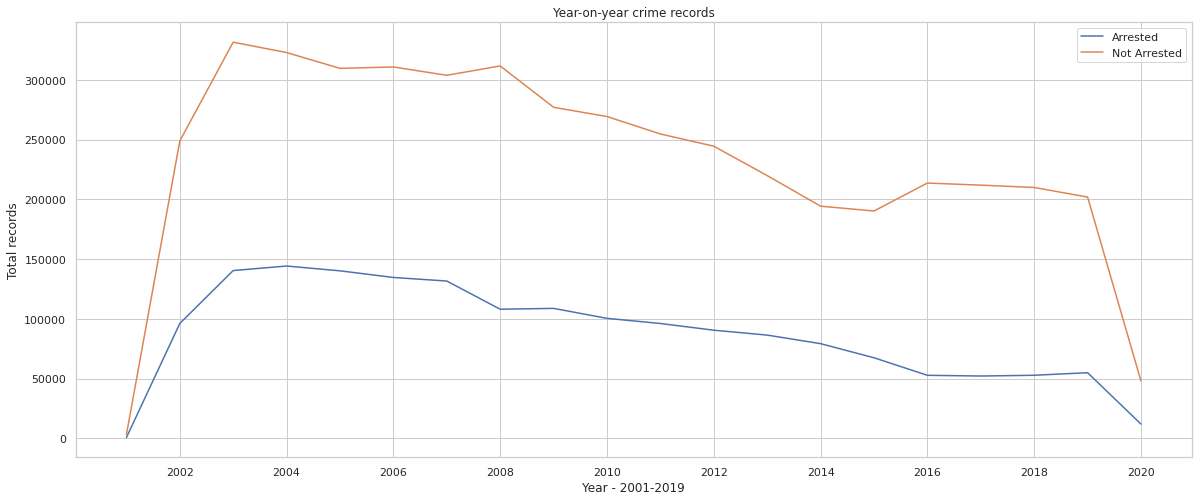

In [49]:
# Data for plotting
arrested = arrest_date_df[arrest_date_df['arrest'] == True]
not_arrested = arrest_date_df[arrest_date_df['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2001-2019', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Time of the day with the highest crime rate
- what time of the day are criminals busiest?

In [0]:
# Extract the "hour" field from the date into a separate column called "hour"
df_hour = df.withColumn('hour', hour(df['date_time']))

In [0]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [0]:
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [53]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')
hourly_count_pddf 

,hour,count
22,0,350517
2,1,203655
21,2,171470
6,3,138579
13,4,104505
8,5,87272
4,6,103043
16,7,147831
14,8,218220
11,9,276515


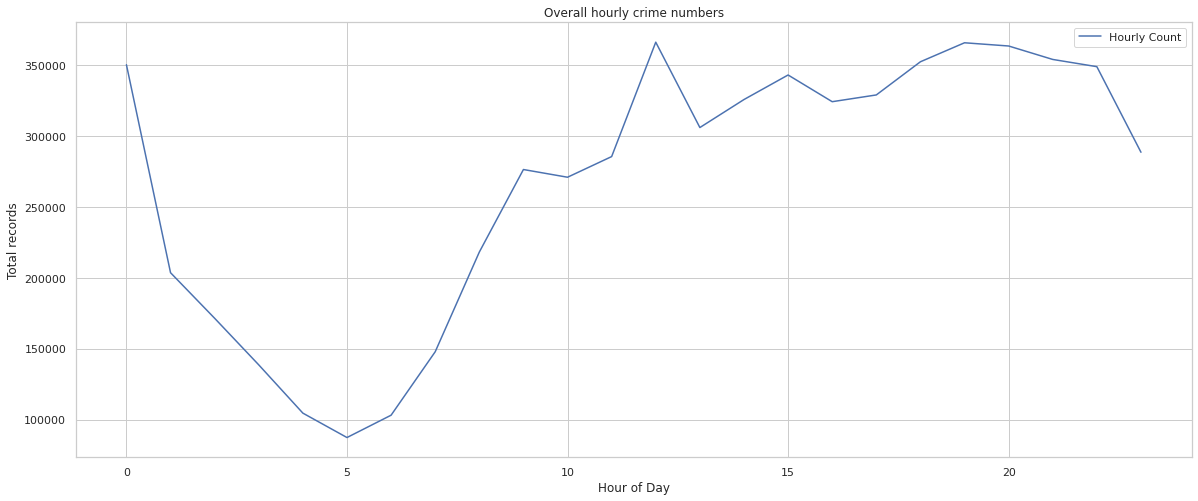

In [54]:
#Plot
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()


### Critical View in crime date and time
- When is the peak of crimal activities?

In [0]:
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [60]:

df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|05/04/2019 02:00:00 PM|2019-01-01|14  |7       |2019|5         |4        |6697       |
|05/22/2019 01:30:00 AM|2019-01-01|1   |4       |2019|5         |22       |6715       |
|05/22/2019 01:42:00 AM|2019-01-01|1   |4       |2019|5         |22       |6715       |
|05/23/2019 03:30:00 PM|2019-01-01|15  |5       |2019|5         |23       |6716       |
|05/24/2019 06:00:00 PM|2019-01-01|18  |6       |2019|5         |24       |6717       |
|06/01/2019 03:00:00 PM|2019-01-01|15  |7       |2019|6         |1        |6725       |
|05/24/2019 03:00:00 AM|2019-01-01|3   |6       |2019|5         |24       |6717       |
|05/24/2019 12:52:00 AM|2019-01-01|0   |6       |2019|5         |24       |6717       |
|05/24/2019 05:00:00 PM|2019-01-

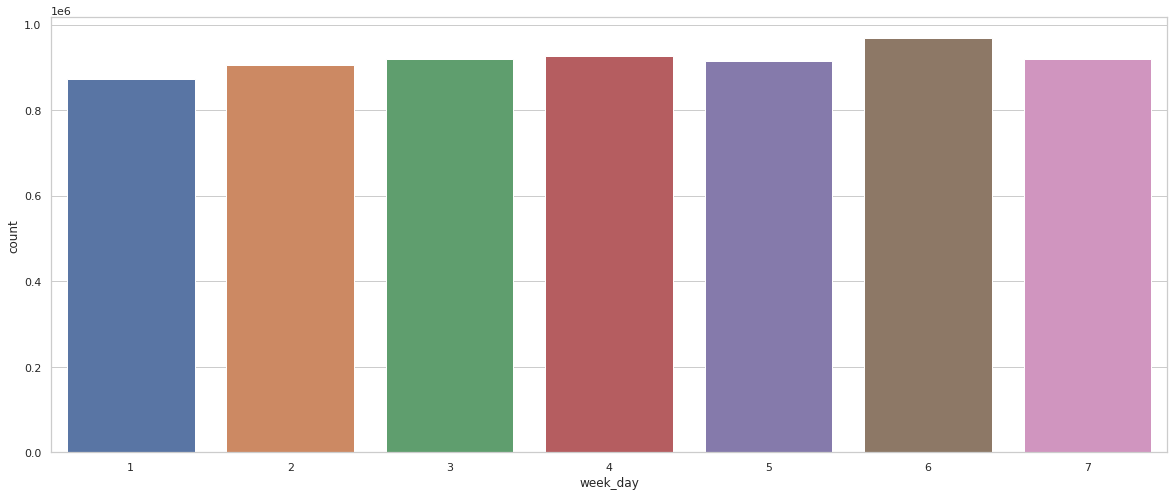

In [0]:
#Ploting the crime count accros days of the week
week_day_crime_counts = df_dates.groupBy('week_day').count()
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

In [61]:
# Ploting crime count across days of the month
month_day_crime_counts = df_dates.groupBy('month_day').count()

month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,245720
14,15,217948
19,20,214331
16,17,212903
9,10,212159
13,14,211626
15,16,211375
17,18,210472
11,12,210150
20,21,210130


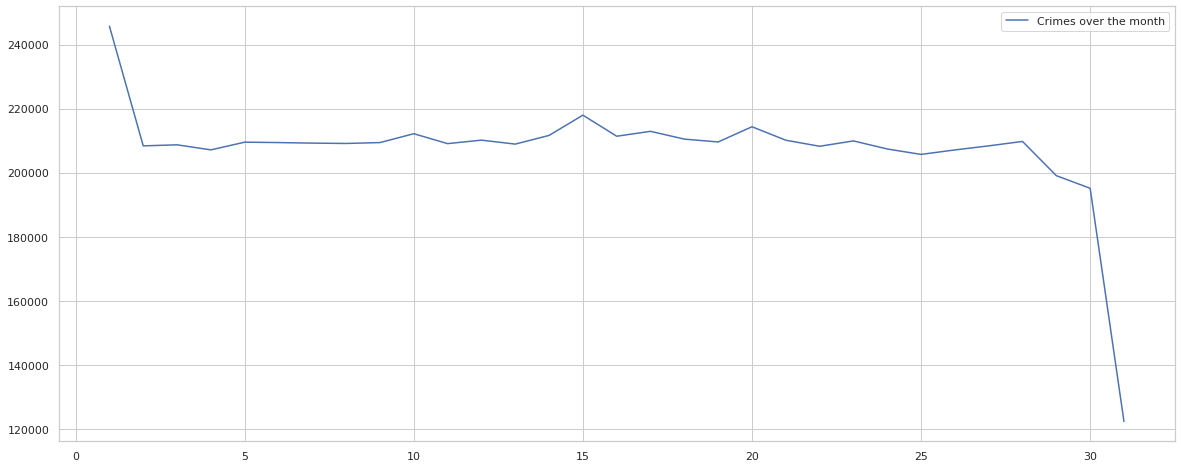

In [62]:
#Plot
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

In [63]:
# Ploting the crime count accros the months of the year
year_month_crime_counts = df_dates.groupBy('year_month').count()
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())
year_month_crime_counts_pddf

,year_month,count
0,1,486632
1,2,429887
2,3,513373
3,4,517462
4,5,581020
5,6,577011
6,7,605743
7,8,599321
8,9,561537
9,10,565134


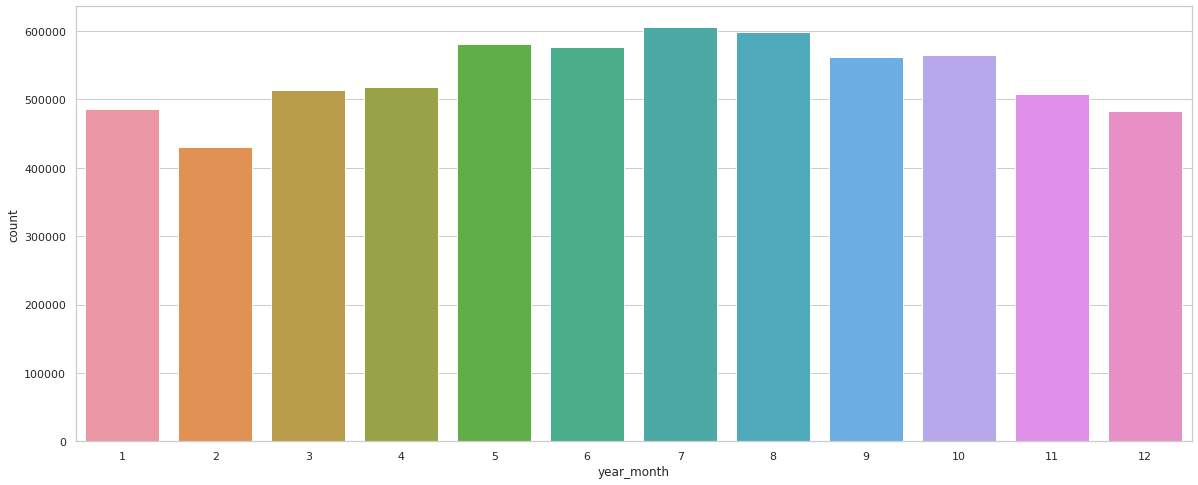

In [64]:
#Plot
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

### Comparing Chicago Community Areas
- chicago has 77 community areas
- we will use a count plot
- Given that we added the area names we wil use to
- Which Communities have the highest crime?
- Which crimes are predominant in each community?


In [66]:
# Community Areas with highest crimes
df_dates_community_areas = df.groupBy('community area','Area Name').count().orderBy('count', ascending=False).show(10)


+--------------+---------------+------+
|community area|      Area Name| count|
+--------------+---------------+------+
|            25|         Austin|407512|
|             8|Near North Side|222954|
|            43|    South Shore|210670|
|            23|  Humboldt Park|203042|
|            28| Near West Side|190707|
|            24|      West Town|188990|
|            67| West Englewood|188062|
|            29| North Lawndale|186674|
|            71| Auburn Gresham|182646|
|            49|       Roseland|171499|
+--------------+---------------+------+
only showing top 10 rows



In [67]:
#Comparing community areas and their crime type
crime_per_Area = df.groupBy('primary Type','community area','Area Name').count().sort('primary Type','community area','Area Name')
crime_per_Area_counts = crime_per_Area.orderBy('count', ascending=False)
crime_per_Area_counts.show(truncate=False)

+---------------+--------------+---------------+-----+
|primary Type   |community area|Area Name      |count|
+---------------+--------------+---------------+-----+
|THEFT          |8             |Near North Side|93454|
|NARCOTICS      |25            |Austin         |90875|
|BATTERY        |25            |Austin         |82301|
|THEFT          |32            |Loop           |81435|
|THEFT          |28            |Near West Side |63150|
|THEFT          |24            |West Town      |61732|
|THEFT          |25            |Austin         |53366|
|THEFT          |6             |Lakeview       |47721|
|NARCOTICS      |23            |Humboldt Park  |47164|
|BATTERY        |43            |South Shore    |46558|
|THEFT          |7             |Lincoln Park   |45214|
|BATTERY        |67            |West Englewood |44758|
|BATTERY        |68            |Englewood      |42809|
|NARCOTICS      |29            |North Lawndale |42434|
|BATTERY        |29            |North Lawndale |41119|
|BATTERY  

In [0]:
# Comparing crime type in each location
crime_per_location = df.groupBy('primary Type','Location Description').count().sort('primary Type','Location description')
crime_per_location_counts = crime_per_location.orderBy('count', ascending=False)
crime_per_location_counts.show(truncate=False)

+-------------------+--------------------+------+
|primary Type       |Location Description|count |
+-------------------+--------------------+------+
|THEFT              |STREET              |369221|
|CRIMINAL DAMAGE    |STREET              |261941|
|BATTERY            |APARTMENT           |246702|
|BATTERY            |RESIDENCE           |239743|
|MOTOR VEHICLE THEFT|STREET              |229844|
|NARCOTICS          |STREET              |226152|
|NARCOTICS          |SIDEWALK            |213084|
|BATTERY            |STREET              |197739|
|OTHER OFFENSE      |RESIDENCE           |178826|
|BATTERY            |SIDEWALK            |178817|
|CRIMINAL DAMAGE    |RESIDENCE           |137195|
|THEFT              |RESIDENCE           |137086|
|BURGLARY           |RESIDENCE           |124717|
|BURGLARY           |APARTMENT           |110098|
|ASSAULT            |STREET              |80897 |
|CRIMINAL DAMAGE    |APARTMENT           |80089 |
|ROBBERY            |SIDEWALK            |77411 |


### Domestic Crimes
- How does domestic crime compare with other crimes?

In [68]:
# Boolean count of Domestic Crimes
df.groupBy('Domestic').count().show()

+--------+-------+
|Domestic|  count|
+--------+-------+
|    true| 865249|
|   false|5562904|
+--------+-------+



### Amount Of Theft each Year

In [81]:
# Select DataFrame approach
new_df=df.filter(col('primary Type') == 'THEFT')
new_df.show()

+--------------+---------------+--------+-----------+--------------------+--------------------+----+------------+---------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+
|Community Area|      Area Name|      ID|Case Number|                Date|               Block|IUCR|Primary Type|    Description|Location Description|Arrest|Domestic|Beat|District|Ward|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|          date_time|     month|
+--------------+---------------+--------+-----------+--------------------+--------------------+----+------------+---------------+--------------------+------+--------+----+--------+----+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+
|             8|Near N

In [82]:
# Amount of Theft each Year
Theft_per_year = new_df.groupBy('primary Type','Year').count().sort('primary Type','Year')
Theft_per_year_counts = Theft_per_year.orderBy('count', ascending=False)
Theft_per_year_counts.show(truncate=False)

+------------+----+-----+
|primary Type|Year|count|
+------------+----+-----+
|THEFT       |2003|97795|
|THEFT       |2004|94631|
|THEFT       |2008|86340|
|THEFT       |2006|85222|
|THEFT       |2007|84557|
|THEFT       |2005|84298|
|THEFT       |2009|79246|
|THEFT       |2010|76684|
|THEFT       |2012|75115|
|THEFT       |2011|74853|
|THEFT       |2002|71726|
|THEFT       |2013|71457|
|THEFT       |2018|64024|
|THEFT       |2017|63584|
|THEFT       |2019|61613|
|THEFT       |2014|61350|
|THEFT       |2016|61039|
|THEFT       |2015|56696|
|THEFT       |2020|13271|
|THEFT       |2001|1232 |
+------------+----+-----+



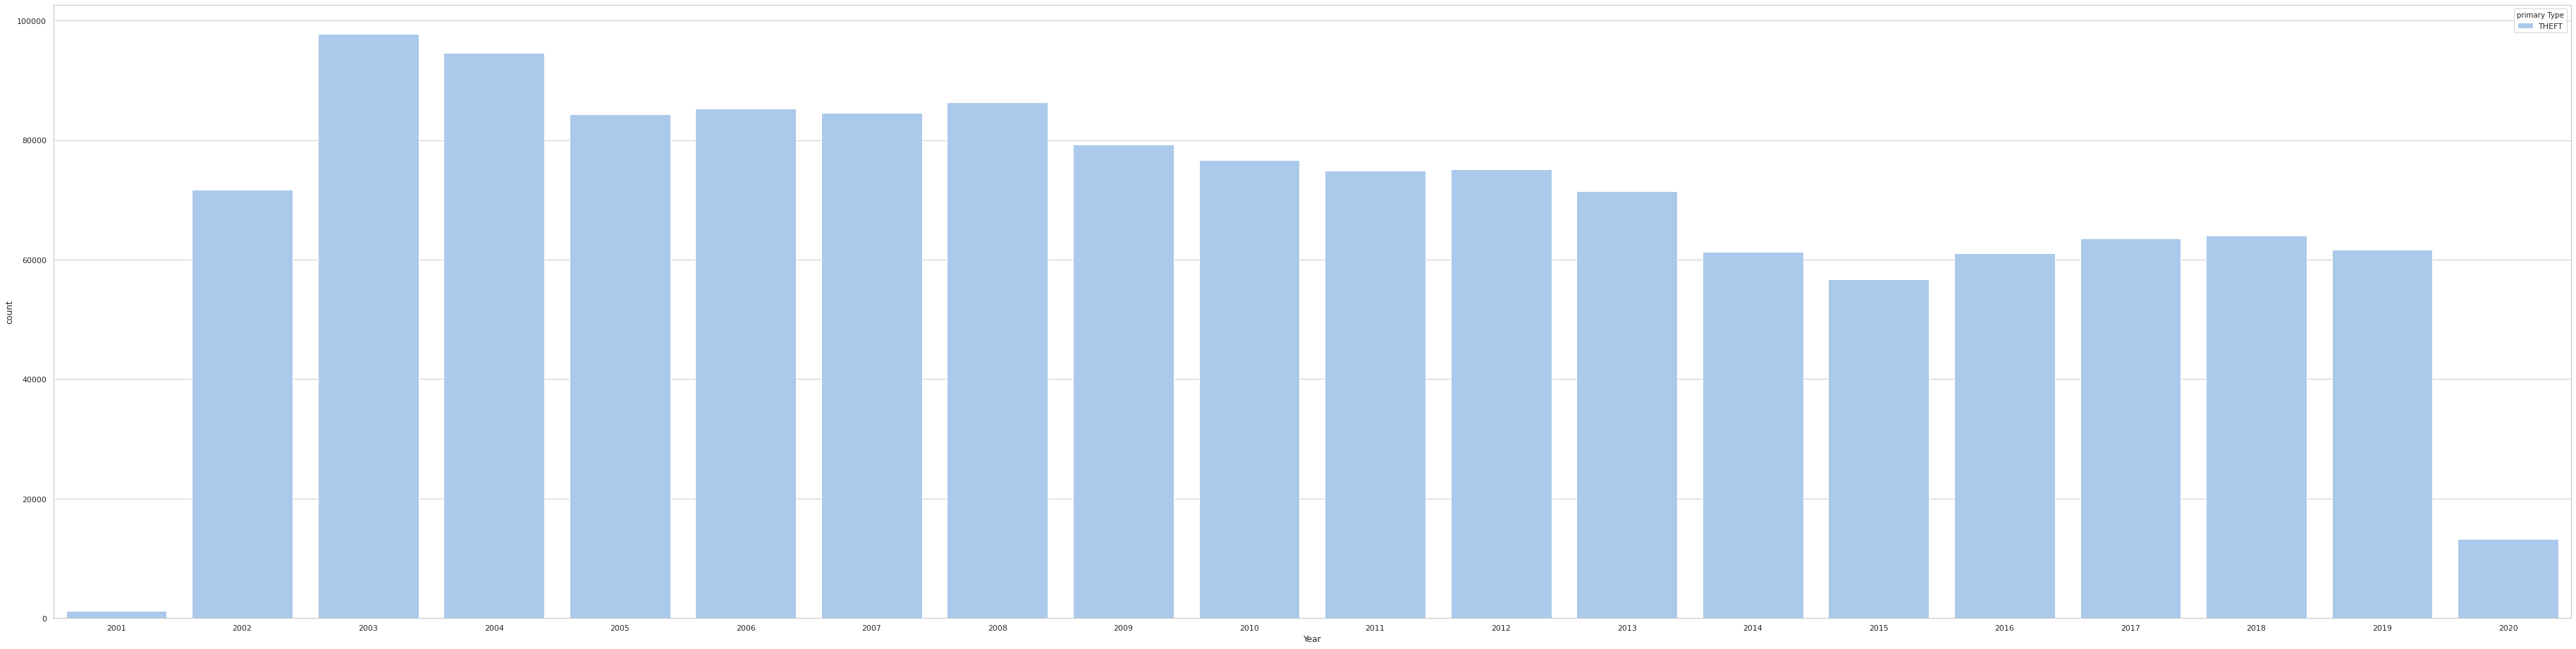

In [83]:
# Plotting
Theft_Year_df=Theft_per_year_counts.toPandas()

plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=Theft_Year_df, x='Year', y='count', hue='primary Type', palette='pastel')



### References
- https://chrispfchung.github.io/import%20data/pyspark-by-example/
- https://github.com/ernest-kiwele/chicago-crime-analysis-apache-spark/blob/master/spark-ml/chicago-crime-data-on-spark.ipynb
- https://medium.com/@stafa002/my-notes-on-chicago-crime-data-analysis-ed66915dbb20
-https://hackingandslacking.com/pyspark-macro-dataframe-methods-join-and-groupby-477a57836ff
-https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/6231273882341974/3878104757667614/987168565515839/latest.html